We will use the daily spreadsheet from EU CDC containing new cases and deaths per country per day.

In [1]:
!rm COVID-19-geographic-disbtribution-worldwide.xlsx
!wget https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx

--2020-04-28 11:32:54--  https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx
Resolving www.ecdc.europa.eu (www.ecdc.europa.eu)... 13.227.198.54, 13.227.198.98, 13.227.198.83, ...
Connecting to www.ecdc.europa.eu (www.ecdc.europa.eu)|13.227.198.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 633099 (618K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘COVID-19-geographic-disbtribution-worldwide.xlsx’

COVID-19-geographic 100%[===================>] 618.26K  --.-KB/s    in 0.09s   

2020-04-28 11:32:54 (6.40 MB/s) - ‘COVID-19-geographic-disbtribution-worldwide.xlsx’ saved [633099/633099]



Get Pandas and NumPy for feature engineering and calculations and get plots inline.

In [2]:
import pandas as pd
import numpy  as np

%matplotlib inline

We read our dataframe directly from the downloaded Excel file and have a look at the first 10 lines for format.

In [3]:
df = pd.read_excel('COVID-19-geographic-disbtribution-worldwide.xlsx')
df.head(10)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,2020-04-27,27,4,2020,68,21,Afghanistan,AF,AFG,37172386.0,Asia
1,2020-04-26,26,4,2020,112,4,Afghanistan,AF,AFG,37172386.0,Asia
2,2020-04-25,25,4,2020,70,1,Afghanistan,AF,AFG,37172386.0,Asia
3,2020-04-24,24,4,2020,105,2,Afghanistan,AF,AFG,37172386.0,Asia
4,2020-04-23,23,4,2020,84,4,Afghanistan,AF,AFG,37172386.0,Asia
5,2020-04-22,22,4,2020,61,1,Afghanistan,AF,AFG,37172386.0,Asia
6,2020-04-21,21,4,2020,35,2,Afghanistan,AF,AFG,37172386.0,Asia
7,2020-04-20,20,4,2020,88,3,Afghanistan,AF,AFG,37172386.0,Asia
8,2020-04-19,19,4,2020,63,0,Afghanistan,AF,AFG,37172386.0,Asia
9,2020-04-18,18,4,2020,51,1,Afghanistan,AF,AFG,37172386.0,Asia


Use a count on columns to see how many missing values we have. We would like to compare countries by geoId.

In [4]:
df.count()

dateRep                    13418
day                        13418
month                      13418
year                       13418
cases                      13418
deaths                     13418
countriesAndTerritories    13418
geoId                      13374
countryterritoryCode       13270
popData2018                13297
continentExp               13418
dtype: int64

Because we seem to miss some geoID entries, we will drop them. The resulting dataframe will be pivoted so we get one row per date, columns by geoId and the number of new cases and deaths in the cells. Again, show the first 10 rows to check our pivot.

In [5]:
df_geo = df.dropna(subset=['geoId']).pivot(index='dateRep', columns='geoId', values=['cases', 'deaths'])
df_geo.head(10)

cases                                          ... deaths          \
geoId         AD   AE   AF  AG  AI  AL   AM  AO  AR   AT  ...     VC  VE  VG   
dateRep                                                   ...                  
2019-12-31   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN NaN   
2020-01-01   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN NaN   
2020-01-02   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN NaN   
2020-01-03   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN NaN   
2020-01-04   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN NaN   
2020-01-05   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN NaN   
2020-01-06   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN NaN   
2020-01-07   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN NaN   
2020-01-08   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN NaN   
2020-01-09   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN NaN   

                                         
geoId       VI   VN  XK  YE  ZA  ZM  ZW  
dateRep                                  
2019-12-31 NaN  0.0 NaN NaN NaN NaN NaN  
2020-01-01 NaN  0.0 NaN NaN NaN NaN NaN  
2020-01-02 NaN  0.0 NaN NaN NaN NaN NaN  
2020-01-03 NaN  0.0 NaN NaN NaN NaN NaN  
2020-01-04 NaN  0.0 NaN NaN NaN NaN NaN  
2020-01-05 NaN  0.0 NaN NaN NaN NaN NaN  
2020-01-06 NaN  0.0 NaN NaN NaN NaN NaN  
2020-01-07 NaN  0.0 NaN NaN NaN NaN NaN  
2020-01-08 NaN  0.0 NaN NaN NaN NaN NaN  
2020-01-09 NaN  0.0 NaN NaN NaN NaN NaN  

[10 rows x 412 columns]

Now for some modeling. The _curve_ representing current infected cases can also be interpreted as a smoothed version of the new arriving cases, because using the sum over the last 14 days is just the mean times 14. It has the general shape of a gaussian curve, based on the underlying probability distribution of the disease spread. Gaussian curves have the nice property that the logarithm is a parabola.

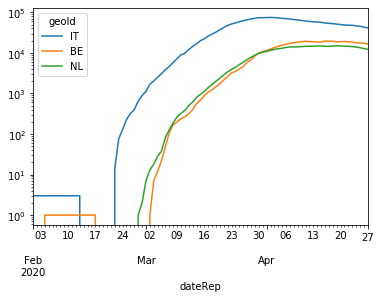

In [6]:
(df_geo['cases'][['IT', 'BE', 'NL']].rolling(14).sum().loc['20200201':]).plot(logy=True)

Let's start with __NL__ as an exploration and leave generalization for later. We create a dataframe `dg` with the non zero (for the logarithm) cases from the original data and sort by date ascending, which is useful for the visualizations later on.

In [7]:
dg = df[(df['geoId'] == 'NL') & (df['cases'] > 0)].sort_values(['dateRep'])
dg.describe()

,day,month,year,cases,deaths,popData2018
count,60.000000,60.000000,60.0,60.000000,60.000000,60.0
mean,15.516667,3.416667,2020.0,630.750000,74.583333,17231017.0
std,8.757547,0.561223,0.0,441.052348,66.084766,0.0
min,1.000000,2.000000,2020.0,1.000000,0.000000,17231017.0
25%,8.000000,3.000000,2020.0,146.500000,1.750000,17231017.0
50%,15.500000,3.000000,2020.0,731.500000,79.000000,17231017.0
75%,23.000000,4.000000,2020.0,1019.000000,132.000000,17231017.0
max,31.000000,4.000000,2020.0,1335.000000,234.000000,17231017.0


Most algorithms (such as our curve fitter) only take numerical data as inputs for a model, so we add a column representing the date as days since January 1st, 2019. We take a rolling week window to smooth the weekly reporting cycle for cases, because many of the cases over the weekend end up in the reported data for Tuesdays and Wednesdays. Now we can take the logarithm to create our parabola curve for fitting.

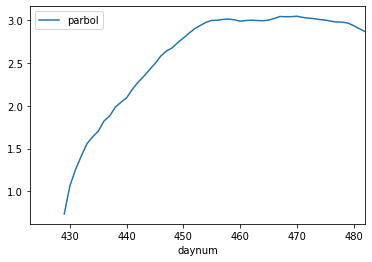

In [8]:
dg['daynum'] = (dg['dateRep'] - pd.Timestamp('2019-01-01')).dt.days.astype('int')
dg['parbol'] = np.log10(dg['cases'].rolling(7).mean())

dg.plot(x='daynum', y='parbol')

Now we can use polynomial regression to estimate the curve with `polyfit`. We are looking for a parabola, so we use a second order approximation. The outputs are factors a, b, and c for the function `ax^2 + bx + c`. The curve fitter doesn't accept missing values (created because of the rolling window), so we drop those first creating a dataframe `dt` for the actual fit.

In [9]:
dt = dg.dropna()
fit = np.polyfit(dt['daynum'], dt['parbol'], 2)
print(fit)

[-1.47810764e-03  1.37852430e+00 -3.18288007e+02]


Once we have those, we take the exponential and we get the estimated curve for that time series. The `polyval` function takes the results of `polyfit` and applies them to the input data.

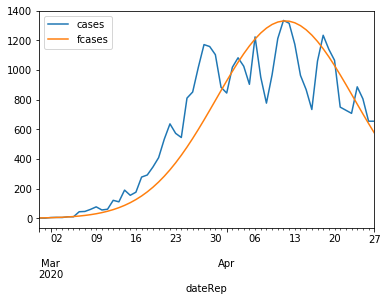

In [10]:
dg['fcases'] = 10 ** np.polyval(fit, dg['daynum'])
dg.plot(x='dateRep', y=['cases', 'fcases'])

That shows a decent fit. Lets prepare a prediction by creating a dataframe `dp` with 30 future dates and score them.

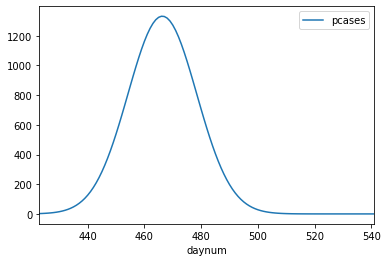

In [11]:
dp = pd.DataFrame({'daynum': range(dg['daynum'].min(), dg['daynum'].max() + 60)})
dp['pcases'] = 10 ** np.polyval(fit, dp['daynum'])
dp.plot(x='daynum', y='pcases')

Finally we concatenate the predicted data to the original dataframe so we can use it in our visualizations.

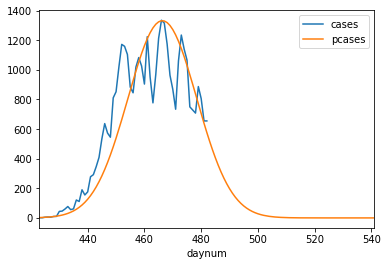

In [12]:
dg = pd.concat([dg, dp], axis=0, ignore_index=False, sort=True)
dg.plot(x='daynum', y=['cases', 'pcases'])

Keep exploring! Stay home, wash your hands, keep your distance.